In [869]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, rankdata
from matplotlib import pyplot as plt
from datetime import datetime

# Types
from collections.abc import Sequence
from typing import Literal
import numpy.typing as npt

## Data Generation

### Test Data (10K points)

In [849]:
mu_0 = np.repeat(0, 10)
sigma_0 = np.zeros((10,10))
sigma_0[:4,:4] = 0.1
sigma_0[4:,4:] = 0.2
np.fill_diagonal(sigma_0, 1)
sigma_0

array([[1. , 0.1, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 1. , 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.1, 0.1, 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 1. , 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 1. , 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 1. , 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 1. , 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 0.2, 1. ]])

In [850]:
mu_1 = np.concatenate([np.repeat(1, 4), np.repeat(0,6)])
sigma_1 = np.zeros((10,10))
sigma_1[:4,:4] = 0.7
sigma_1[4:,4:] = 0.2
np.fill_diagonal(sigma_1, 1)
sigma_1

array([[1. , 0.7, 0.7, 0.7, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.7, 1. , 0.7, 0.7, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.7, 0.7, 1. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.7, 0.7, 0.7, 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 1. , 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 1. , 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 1. , 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 1. , 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 0.2, 1. ]])

In [851]:
np.random.seed(0)

In [852]:
x0_mat = multivariate_normal.rvs(mean=mu_0, cov=sigma_0, size=9000)
x0_mat.shape

(9000, 10)

In [853]:
x1_mat = multivariate_normal.rvs(mean=mu_1, cov=sigma_1, size=1000)
x1_mat.shape

(1000, 10)

In [854]:
x_mat = np.concatenate([x0_mat, x1_mat], axis=0)
print(x_mat, x_mat.shape)

[[ 0.5759906  -0.29167903 -2.54721471 ... -0.92724267 -1.90624594
  -0.10730083]
 [-0.20380716 -1.21395198 -1.21750569 ...  0.58286229 -0.2478649
   0.42400304]
 [ 0.33758688 -2.25905186 -0.50910674 ...  0.24076747  0.2701972
   2.10823246]
 ...
 [ 1.96145657  1.21480304  1.05050281 ... -0.57582602 -1.25242783
  -0.96151189]
 [ 1.17853288  0.90295401  1.59765197 ... -0.0956288  -0.3299179
   0.61938298]
 [ 0.9671702  -0.21628135  1.11291407 ...  1.23453746  0.70059948
  -1.39064692]] (10000, 10)


In [855]:
y_vec = np.concatenate([np.repeat(0,9000),np.repeat(1,1000)])
y_vec

array([0, 0, 0, ..., 1, 1, 1])

### Training Data

In [875]:
def generate_training_data(sample_size: tuple[int, int], shuffle=True) -> tuple[npt.NDArray, npt.NDArray]:
    '''
    Parameters:
        sample_size: a tuple of (h0_size, h1_size)
        shuffle: should we shuffle the training data (otherwise the order will be: all h0 samples, then all h1 samples)
    Returns:
        tuple of (x_values, labels)
    '''
    np.random.seed(100)
    
    # Generate the data
    x0_train = multivariate_normal.rvs(mean=mu_0, cov=sigma_0, size=sample_size[0])
    x1_train = multivariate_normal.rvs(mean=mu_1, cov=sigma_1, size=sample_size[1])
    x_train = np.concatenate([x0_train, x1_train], axis=0)
    y_train = np.concatenate([np.repeat(0,sample_size[0]), np.repeat(1,sample_size[1])])
    
    # shuffle if required 
    if shuffle:
        rng = np.random.default_rng(123)
        train_data = np.concatenate([x_train, y_train.reshape(-1,1)],axis=1) # we want to shuffle x and y in the same order...
        rng.shuffle(train_data)
        #split back to x_train and y_train
        x_train = train_data[:,:10]
        y_train = train_data[:,10:]
        y_train = y_train.reshape([-1])
        
    print(F"train data shape for size {sample_size}:\r\n\tx: {x_train.shape}\r\n\t y: {y_train.shape}")
    return (x_train, y_train)

#### 10K Sampling

In [856]:
np.random.seed(100)

In [857]:
x0_train = multivariate_normal.rvs(mean=mu_0, cov=sigma_0, size=5000)
x0_train

array([[ 0.75195769, -1.18688619, -0.51899192, ...,  1.01442206,
         1.5618069 ,  1.42688451],
       [-0.72755362, -0.00931606, -0.83429196, ...,  0.95514427,
         0.13777946, -0.68179595],
       [-1.08579   , -1.37235633, -0.21654971, ..., -1.14701739,
        -0.57499677, -0.70105629],
       ...,
       [-0.32789844, -0.58753543, -1.43607536, ...,  0.13608292,
         0.73393843,  0.67254727],
       [ 0.37785074,  0.72257045, -0.54754785, ..., -0.22206782,
         0.20278724,  0.35825009],
       [ 0.90596328,  0.37497375, -0.38979323, ..., -0.04699126,
         0.79774736, -0.91727503]])

In [858]:
x1_train = multivariate_normal.rvs(mean=mu_1, cov=sigma_1, size=5000)
x1_train

array([[-0.00713509,  0.39342399,  0.4545551 , ...,  0.50809967,
        -0.00566893,  0.44951378],
       [ 0.79759881,  0.25775381,  1.36778205, ...,  1.44785118,
        -0.99047656,  0.86564556],
       [ 0.30095622,  1.15496158,  1.95267124, ..., -0.19998624,
        -0.16709896,  1.81143114],
       ...,
       [ 1.77724335,  1.170421  ,  1.85973255, ...,  1.1564544 ,
        -0.05252496, -0.1258319 ],
       [ 2.55281569,  2.40355136,  2.37559979, ..., -1.77462287,
         0.66957382,  0.86275165],
       [-0.3869522 ,  1.17620175,  0.61178011, ...,  0.21622065,
        -0.54707131, -0.48503961]])

In [859]:
x_train = np.concatenate([x0_train, x1_train], axis=0)
y_train = np.concatenate([np.repeat(0,5000), np.repeat(1,5000)])

x_train.shape, y_train.shape

((10000, 10), (10000,))

In [860]:
# shuffle the training data (would provide better convergence?)
rng = np.random.default_rng(123)
train_data = np.concatenate([x_train, y_train.reshape(-1,1)],axis=1)
rng.shuffle(train_data)
train_data.shape

(10000, 11)

In [861]:
#split back to x_train and y_train
x_train = train_data[:,:10]
y_train = train_data[:,10:]
x_train.shape, y_train.shape

((10000, 10), (10000, 1))

In [862]:
y_train = y_train.reshape([-1])

#### 200K Sampling

In [415]:
np.random.seed(100)

In [416]:
x0_train = multivariate_normal.rvs(mean=mu_0, cov=sigma_0, size=100000)
x0_train

array([[ 0.75195769, -1.18688619, -0.51899192, ...,  1.01442206,
         1.5618069 ,  1.42688451],
       [-0.72755362, -0.00931606, -0.83429196, ...,  0.95514427,
         0.13777946, -0.68179595],
       [-1.08579   , -1.37235633, -0.21654971, ..., -1.14701739,
        -0.57499677, -0.70105629],
       ...,
       [ 1.48661771,  0.38206999,  1.12059166, ...,  1.17001683,
         0.68530547,  0.90585144],
       [-1.92222173, -0.89532607, -1.30362672, ...,  1.24211086,
         0.43979592, -0.99295657],
       [-2.34190791,  0.28913327,  0.82547119, ..., -0.7384281 ,
        -1.28147355, -0.73751658]])

In [417]:
x1_train = multivariate_normal.rvs(mean=mu_1, cov=sigma_1, size=100000)
x1_train

array([[ 0.57006999,  0.29062715,  0.9163452 , ...,  0.53681761,
         1.71404537,  0.84276572],
       [ 0.08956264, -0.34257759, -0.32587306, ..., -1.22455784,
         0.00772838,  1.32071778],
       [ 1.98304516,  1.51219089,  1.45467445, ...,  0.78679905,
         0.83199825,  0.27598463],
       ...,
       [ 0.23153942,  0.68410046, -0.17105731, ..., -0.22923756,
         1.00849943,  0.24905392],
       [ 0.07008673,  1.43394886,  0.56298714, ..., -0.60031024,
        -0.91449731, -1.15274422],
       [ 2.41359513,  2.1040162 ,  1.78141363, ...,  1.40520731,
        -0.33691682,  1.57206308]])

In [418]:
x_train = np.concatenate([x0_train, x1_train], axis=0)
y_train = np.concatenate([np.repeat(0,100000), np.repeat(1,100000)])

x_train.shape, y_train.shape

((200000, 10), (200000,))

In [419]:
# shuffle the training data (would provide better convergence?)
rng = np.random.default_rng(123)
train_data = np.concatenate([x_train, y_train.reshape(-1,1)],axis=1)
rng.shuffle(train_data)
train_data.shape

(200000, 11)

In [420]:
#split back to x_train and y_train
x_train = train_data[:,:10]
y_train = train_data[:,10:]
x_train.shape, y_train.shape

((200000, 10), (200000, 1))

In [421]:
y_train = y_train.reshape([-1])

#### Calibration Set

In [607]:
np.random.seed(200)

In [608]:
x0_calibration = multivariate_normal.rvs(mean=mu_0, cov=sigma_0, size=1000)
x0_calibration

array([[-0.50454249, -1.61804209, -1.17147541, ...,  0.42842508,
         0.9378782 ,  1.09080766],
       [-0.56759441, -1.29131436, -1.94589582, ...,  0.62341105,
        -0.55407096,  1.57402844],
       [-1.75557902,  0.29421355, -0.88731079, ...,  0.49005123,
        -0.63054804,  0.73208775],
       ...,
       [-0.45044224,  0.26544515,  0.4937829 , ..., -0.54235586,
        -0.63871574, -0.9854256 ],
       [ 0.1199062 , -0.28458449,  0.27879168, ...,  0.04721642,
        -1.05980316,  0.00245476],
       [ 0.22104198,  0.52393027, -0.23864402, ...,  1.0104947 ,
        -0.67750248,  0.79847223]])

In [609]:
x1_calibration = multivariate_normal.rvs(mean=mu_1, cov=sigma_1, size=1000)
x1_calibration

array([[-0.74149314, -0.7192464 , -0.65777608, ...,  0.51678518,
         0.16184265,  1.59533601],
       [ 0.78370859,  0.36039197,  1.5702933 , ..., -0.65925995,
        -0.71594695,  1.10088011],
       [ 0.30652991,  0.29802768, -0.11063229, ..., -1.72660427,
        -0.06729839, -0.05443262],
       ...,
       [ 1.36350991,  1.12005072,  1.54603508, ..., -0.46339654,
         0.32171073, -1.55569111],
       [ 2.11302149,  1.74323725,  2.26014432, ..., -2.21733605,
        -0.12411581, -1.36656523],
       [-0.50755397, -0.78156237, -0.72824421, ...,  0.96507859,
        -0.53682886, -0.0837731 ]])

In [610]:
x_calibration = np.concatenate([x0_calibration, x1_calibration], axis=0)
y_calibration = np.concatenate([np.repeat(0,1000), np.repeat(1,1000)])

x_calibration.shape, y_calibration.shape

((2000, 10), (2000,))

In [611]:
# shuffle the training data (would provide better convergence?)
rng = np.random.default_rng(123)
calibration_data = np.concatenate([x_calibration, y_calibration.reshape(-1,1)],axis=1)
rng.shuffle(calibration_data)
calibration_data.shape

(2000, 11)

In [612]:
#split back to x_train and y_train
x_calibration = calibration_data[:,:10]
y_calibration = calibration_data[:,10:]
x_calibration.shape, y_calibration.shape

((2000, 10), (2000, 1))

In [613]:
y_calibration = y_calibration.reshape([-1]).astype(np.int64)
y_calibration.dtype

dtype('int64')

## FDR using Optimal Classifier

In [614]:
log_f0 = multivariate_normal.logpdf(x_mat, mean=mu_0, cov=sigma_0) # Get all values of x.mat as if it came from density f0
log_f0.shape

(10000,)

In [615]:
log_f1 = multivariate_normal.logpdf(x_mat, mean=mu_1, cov=sigma_1) # Get all values of x.mat as if it came from density f1
log_f1.shape

(10000,)

In [616]:
# In Bayesian Decision Theory - The class with the highest posterior probability, is the one which provides the minimum risk
# So, fdr_vec is the "p values", which is actually the posterior calculated by [prior0 * Pr(f0|x)] / [(prior0 * Pr(f0|x)) + prior1*Pr(f1|x)]
fdr_vec = 0.90 * np.exp(log_f0) / (0.1*np.exp(log_f1) + 0.9*np.exp(log_f0)) 
fdr_vec.shape

(10000,)

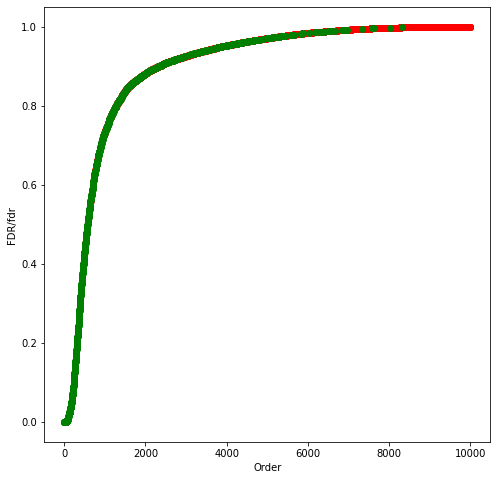

In [617]:
plt.figure(figsize=(8,8))
plt.scatter(rankdata(fdr_vec)[:9000], fdr_vec[:9000], marker="o", label="Ranked fdr", s=30 ,c='red')
plt.plot(rankdata(fdr_vec)[9000:], fdr_vec[9000:], marker="o", c='green', ls="none")
plt.xlabel("Order")
plt.ylabel("FDR/fdr")
plt.show()

In [618]:
num_rej = np.sum(np.cumsum(np.sort(fdr_vec))/np.arange(1,10000+1) <= 0.10)
print(F"num rej: {num_rej}")
# Find the number of false positives
pd.crosstab(rankdata(fdr_vec) <= num_rej,np.concatenate([np.repeat(True, 9000), np.repeat(False, 1000)]), colnames=['H0'], rownames=['is rejected'])

num rej: 393


H0,False,True
is rejected,,
False,650,8957
True,350,43


## Machine Learning

* MC Dropout MLP + CrossEntorpy using 10K Training Data
    * ratio 9:1 of h0/h1
    * ratio 5:5 of h0/h1
* MC Dropout MLP + CrossEntorpy using 100K Training Data
* LDA by sampling variance and mean
* Standard MLP + Softmax ?
* Standard MLP + Softmax + calibration?
* Random Forest? supervised / unsupervised?

In [619]:
import torch
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset as Dataset
import sklearn
from sklearn.model_selection import train_test_split

In [620]:
torch.set_default_dtype(torch.double)

#### Dataloaders

In [621]:
# Lets get the training set as Dataset so we can mini-batch (faster training)
class SimpleDataSet(Dataset):
    def __init__(self, x, y):
        super(SimpleDataSet, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [675]:
y_train = np.array(y_train,dtype=np.int64)
training_dataset = SimpleDataSet(x_train, y_train)
train_loader = Data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)

In [676]:
test_dataset = SimpleDataSet(x_mat, y_vec)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=20, shuffle=False)

### ML Infra

In [555]:
def calibrate_on_temperature(model, calibration_loader):
    """
    Tune the tempearature of the model (using the validation set).
    We're going to set it to optimize NLL.
    valid_loader (DataLoader): validation set loader
    """
    nll_criterion = nn.CrossEntropyLoss()
    # ece_criterion = metrics.ECELoss()

    # First: collect all the logits and labels for the validation set
    logits_list = []
    labels_list = []
    with torch.no_grad():
        for input, label in calibration_loader:
            logits,_ = model(input)
            logits_list.append(logits)
            labels_list.append(label)
        logits = torch.cat(logits_list)
        labels = torch.cat(labels_list)

    # print(F"logits: {logits}")
    # print(F"labels: {labels}")
    # Calculate NLL and ECE before temperature scaling
    before_temperature_nll = nll_criterion(logits, labels).item()
    # before_temperature_ece = ece_criterion.loss(logits.numpy(),labels.numpy(),15)
    #before_temperature_ece = ece_criterion(logits, labels).item()
    #ece_2 = ece_criterion_2.loss(logits,labels)
    # print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))
    print('Before temperature - NLL: %.3f' % (before_temperature_nll))
    #print(ece_2)
    # Next: optimize the temperature w.r.t. NLL
    optimizer = torch.optim.LBFGS([model.temperature], lr=0.05, max_iter=500)

    def eval():
        loss = nll_criterion(model.temperature_scale(logits), labels)
        loss.backward()
        return loss
    optimizer.step(eval)

    # Calculate NLL and ECE after temperature scaling
    after_temperature_nll = nll_criterion(model.temperature_scale(logits), labels).item()
    # after_temperature_ece = ece_criterion.loss(temperature_scale(logits).detach().numpy(),labels.numpy(),15)
    #after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
    print('Optimal temperature: %.3f' % model.temperature.item())
    # print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))
    print('After temperature - NLL: %.3f' % (after_temperature_nll))
    
    return model


In [624]:
def get_accuracy(model, data_loader):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)  # The "1" is acutally misleading - it's the dimension to search the max in, *NOT* a value to compare to.
                                                        # This acutally returns the indices of the highest prediction for each row, 
                                                        # but since the index is 1-1 with the predicted digit, we use it as the label

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [625]:
def epoch_step(loader, criterion, model, optimizer, train=True):
    '''
    Implementation a single epoch for the training/validation loop.
    '''        
    
    model.train() if train else model.eval() # Set the currnet mode
    
    running_loss = 0
    
    # Each iteration gets a batch from the train loader
    for X, y_true in loader:
        optimizer.zero_grad() if train else None
        
        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0) # X.size(0) is the size of the BATCH, thi is required for calculating the avg loss 
                                                # of the epoch step.
        
        # Backward pass, only required in training the model
        if train:
            loss.backward()
            optimizer.step()
    
    epoch_loss = running_loss / len(loader.dataset)
    return model, optimizer, epoch_loss

In [626]:
def run_loop(train_loader, validation_loader, criterion, model, optimizer, num_epochs, print_every=1):
    
    # Objects for storing metrics
    best_loss = 1e10
    train_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        #print(f'Epoch: {epoch}\t')
        
        # Training the model
        model, optimizer, train_loss = epoch_step(train_loader, criterion, model, optimizer)
        train_losses.append(train_loss)
        
        
        # # Validation
        # with torch.no_grad():
        #     model, _, validation_loss = epoch_step(validation_loader, criterion, model, None, False)
        #     validation_losses.append(validation_loss)
        
        if epoch % print_every == (print_every - 1):
            train_accuracy = get_accuracy(model, train_loader)
            # validation_accuracy = get_accuracy(model, validation_loader)
            
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  # f'Vaildation loss: {validation_loss:.4f}\t'
                  f'Train accuracy: {100 * train_accuracy:.2f}\t'
                  # f'Vaildation accuracy: {100 * validation_accuracy:.2f}\t'
                  )
            
    # plot_losses(train_losses, validation_losses)
    
    return model, optimizer, (train_losses, validation_losses)

### Deep Bayes MLP (no calibration)

In [627]:
from torch import Tensor
from torch.nn import functional as F

# Defining a dropout layer to also be used for testing
class MCDropout(torch.nn.Dropout):
    def forward(self, input: Tensor) -> Tensor:
        return F.dropout(input, self.p, True, self.inplace)

In [677]:
class DropoutFdr(nn.Module):
    
    def __init__(self):
        
        super(DropoutFdr, self).__init__()
        
        self.classifier = nn.Sequential(
                            torch.nn.Linear(in_features=10, out_features=100),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=100, out_features=100),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=100, out_features=10),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=10, out_features=2)
        )
        
    def forward(self, x):
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities

In [431]:
class DropoutFdrWithTempeature(nn.Module):
    
    def __init__(self):
        
        super(DropoutFdrWithTempeature, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
        self.classifier = nn.Sequential(
                            torch.nn.Linear(in_features=10, out_features=100),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=100, out_features=100),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=100, out_features=10),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=10, out_features=2)
        )
        
    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    def forward(self, x):
        logits = self.classifier(x)
        scaled_logits = self.temperature_scale(logits)
        probabilities = F.softmax(scaled_logits, dim=1)
        return scaled_logits, probabilities

In [700]:
loss_func = torch.nn.CrossEntropyLoss()

In [701]:
learning_rate = 1e-3

In [702]:
model = DropoutFdr()

In [703]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training with SGD (using epoch_step)

In [436]:
model, optimizer, _ = run_loop(train_loader, test_loader, loss_func, model, optimizer, 1000,50)

02:03:24 --- Epoch: 49	Train loss: 0.3997	Train accuracy: 81.09	
02:13:02 --- Epoch: 99	Train loss: 0.3979	Train accuracy: 81.32	
02:22:37 --- Epoch: 149	Train loss: 0.3976	Train accuracy: 81.42	
02:32:13 --- Epoch: 199	Train loss: 0.3964	Train accuracy: 81.29	
02:41:55 --- Epoch: 249	Train loss: 0.3961	Train accuracy: 81.29	
02:51:30 --- Epoch: 299	Train loss: 0.3965	Train accuracy: 81.33	
03:01:07 --- Epoch: 349	Train loss: 0.3961	Train accuracy: 81.04	
03:10:53 --- Epoch: 399	Train loss: 0.3954	Train accuracy: 81.31	
03:20:30 --- Epoch: 449	Train loss: 0.3960	Train accuracy: 81.36	
03:30:08 --- Epoch: 499	Train loss: 0.3953	Train accuracy: 81.25	
03:39:46 --- Epoch: 549	Train loss: 0.3959	Train accuracy: 81.47	
03:49:24 --- Epoch: 599	Train loss: 0.3962	Train accuracy: 81.32	
03:59:02 --- Epoch: 649	Train loss: 0.3959	Train accuracy: 81.37	
04:08:40 --- Epoch: 699	Train loss: 0.3962	Train accuracy: 81.34	
04:18:18 --- Epoch: 749	Train loss: 0.3957	Train accuracy: 81.32	
04:27:57 ---

In [570]:
import copy
original_200k_model = model
copied_200k_model = copy.deepcopy(model)

### Original Training method GD

In [704]:
x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.from_numpy(y_train).view([-1]).type(torch.LongTensor) # We need the "view" to make sure y is 1-dimentional (the default is 2)
print(y_train_tensor)

tensor([0, 1, 1,  ..., 0, 0, 1])


In [705]:
for i in range(1000):
    logits, probabilities = model(x_train_tensor)
    loss = loss_func(logits, y_train_tensor)
    
    print(F"iteration: {i}, loss: {loss.item()}") if i%100==0 else None
    
    model.zero_grad()
    loss.backward()
    
    optimizer.step() # update the weights based on the gradient

iteration: 0, loss: 0.6956054370425354
iteration: 100, loss: 0.4283496063673324
iteration: 200, loss: 0.3963699560255452
iteration: 300, loss: 0.3865170754808455
iteration: 400, loss: 0.3799247908221504
iteration: 500, loss: 0.3741367117529688
iteration: 600, loss: 0.36714169313422546
iteration: 700, loss: 0.3646571672824743
iteration: 800, loss: 0.35922338239559853
iteration: 900, loss: 0.35584893332663964


### Calibrating

In [743]:
calibration_dataset = SimpleDataSet(x_calibration, y_calibration)
calibration_loader = Data.DataLoader(dataset=calibration_dataset)

In [830]:
from importlib import reload
reload(temperature_scaling)

<module 'temperature_scaling' from '/Users/danielputerman/Documents/personal/TAU/thesis/convnet-fdr/temperature_scaling.py'>

In [831]:
import temperature_scaling

scaled_model = temperature_scaling.ModelWithTemperature(model)
scaled_model.set_temperature(calibration_loader)

set temperature
Before temperature - NLL: 0.443, ECE: 0.035
Optimal temperature: 1.448
After temperature - NLL: 0.433, ECE: 0.019


ModelWithTemperature(
  (model): DropoutFdr(
    (classifier): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): ReLU()
      (2): MCDropout(p=0.3, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): ReLU()
      (5): MCDropout(p=0.3, inplace=False)
      (6): Linear(in_features=100, out_features=10, bias=True)
      (7): ReLU()
      (8): MCDropout(p=0.3, inplace=False)
      (9): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [558]:
copied_200k_model = calibrate_on_temperature(copied_200k_model, calibration_loader)

Before temperature - NLL: 0.416
Optimal temperature: 91.856
After temperature - NLL: 0.674


### Testing

In [832]:
x_test_tensor = torch.from_numpy(x_mat).view([-1,10])
y_test_tensor = torch.from_numpy(y_vec).view([-1]).type(torch.LongTensor)
y_test_tensor

tensor([0, 0, 0,  ..., 1, 1, 1])

#### MC Dropout

In [833]:
model.eval()

all_pred_tensor_list = []

# Get all prediction distribution
# The result is 100 of: 
#   A single model pass over all 10K samples. For each sample, the model returns:
#     2 tensors: logits tensor with shape(10K,2) (as there are 2 classes to classify), probabilities tensor with shape(10K,2)
# with torch.no_grad():
#     # y_pred_tensor_list = [(lambda i: model(x_test_tensor)[1])(i) for i in range(100)]
#     for _ in range(100):
#         _, all_class_probabilities = model(x_test_tensor)
#         _, predicted_labels = torch.max(all_class_probabilities, 1)  # The "1" is acutally misleading - it's the dimension to search the max in, *NOT* a value to compare to.
#                                                             # This acutally returns the indices of the highest prediction for each row, 
#                                                             # but since the index is 1-1 with the predicted digit, we use it as the label
#         pred_class_probabilities_tensor = torch.gather(all_class_probabilities, 1, predicted_labels.reshape((-1,1)))
#         pred_class_probabilities_tensor[predicted_labels == 0] = 0 # for a prediction of 0, we don't care about the probabilities
#         all_pred_tensor_list.append(pred_class_probabilities_tensor)

with torch.no_grad():
    for _ in range(100):
        # _, all_class_probabilities = model(x_test_tensor)
        _, all_class_probabilities = scaled_model(x_test_tensor)
        # _, all_class_probabilities = copied_200k_model(x_test_tensor)
        all_pred_tensor_list.append(all_class_probabilities[:,1].reshape((-1,1)))
        
# make predictions a single tensor
all_preds_tensor = torch.cat(all_pred_tensor_list, dim=1)
all_preds_std = torch.std(all_preds_tensor, 1, True)
all_preds_mean = torch.mean(all_preds_tensor, 1)
all_preds_median = torch.median(all_preds_tensor, 1)

(array([1435.,  976.,  795.,  681.,  657.,  614.,  671.,  654.,  654.,
         593.,  477.,  315.,  294.,  197.,  177.,  152.,  122.,  135.,
         143.,  258.]),
 array([1.81806305e-04, 5.00950908e-02, 1.00008375e-01, 1.49921660e-01,
        1.99834944e-01, 2.49748229e-01, 2.99661513e-01, 3.49574797e-01,
        3.99488082e-01, 4.49401366e-01, 4.99314651e-01, 5.49227935e-01,
        5.99141220e-01, 6.49054504e-01, 6.98967789e-01, 7.48881073e-01,
        7.98794357e-01, 8.48707642e-01, 8.98620926e-01, 9.48534211e-01,
        9.98447495e-01]),
 <BarContainer object of 20 artists>)

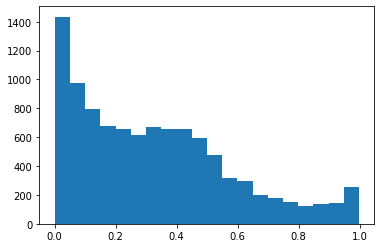

In [834]:
plt.hist(all_preds_mean.numpy(), 20)

(array([  83.,  174.,  319.,  534., 1135., 1530., 1966., 1950., 1203.,
         569.,  288.,  121.,   68.,   28.,   17.,    8.,    2.,    3.,
           0.,    2.]),
 array([0.00086484, 0.01360853, 0.02635222, 0.03909591, 0.0518396 ,
        0.0645833 , 0.07732699, 0.09007068, 0.10281437, 0.11555806,
        0.12830175, 0.14104544, 0.15378913, 0.16653282, 0.17927651,
        0.1920202 , 0.20476389, 0.21750758, 0.23025127, 0.24299496,
        0.25573866]),
 <BarContainer object of 20 artists>)

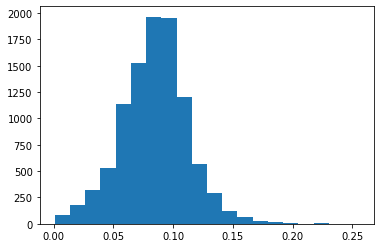

In [748]:
plt.hist(all_preds_std.numpy(), 20)

(array([2007.,  771.,  605.,  569.,  593.,  557.,  666.,  664.,  627.,
         694.,  497.,  344.,  284.,  179.,  161.,  124.,  104.,  111.,
         127.,  316.]),
 array([2.59039814e-08, 4.99987197e-02, 9.99974134e-02, 1.49996107e-01,
        1.99994801e-01, 2.49993495e-01, 2.99992188e-01, 3.49990882e-01,
        3.99989576e-01, 4.49988270e-01, 4.99986963e-01, 5.49985657e-01,
        5.99984351e-01, 6.49983045e-01, 6.99981738e-01, 7.49980432e-01,
        7.99979126e-01, 8.49977820e-01, 8.99976513e-01, 9.49975207e-01,
        9.99973901e-01]),
 <BarContainer object of 20 artists>)

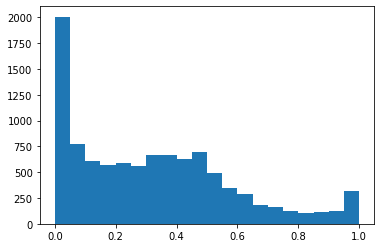

In [749]:
plt.hist(all_preds_median.values.numpy(), 20)

#### Reliability Plots

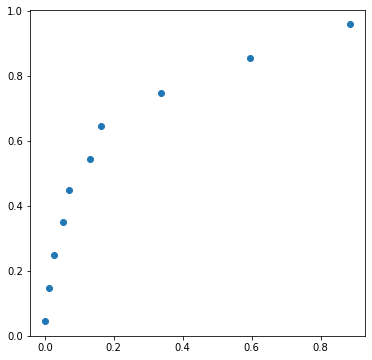

In [750]:
from sklearn.calibration import calibration_curve

all_preds_calibration_data = calibration_curve(y_vec, all_preds_mean.numpy(),n_bins=10)
plt.figure(figsize=(6,6))
plt.scatter(all_preds_calibration_data[0], all_preds_calibration_data[1])

#### Generate p-values

(array([ 242.,  140.,  137.,  118.,  138.,  186.,  193.,  295.,  325.,
         499.,  618.,  660.,  689.,  673.,  623.,  674.,  654.,  802.,
         982., 1352.]),
 array([9.85337028e-04, 5.09246311e-02, 1.00863925e-01, 1.50803219e-01,
        2.00742513e-01, 2.50681807e-01, 3.00621102e-01, 3.50560396e-01,
        4.00499690e-01, 4.50438984e-01, 5.00378278e-01, 5.50317572e-01,
        6.00256866e-01, 6.50196160e-01, 7.00135454e-01, 7.50074748e-01,
        8.00014042e-01, 8.49953336e-01, 8.99892630e-01, 9.49831925e-01,
        9.99771219e-01]),
 <BarContainer object of 20 artists>)

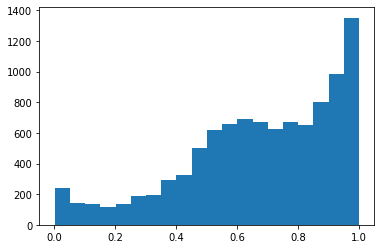

In [751]:
# p_values = torch.clamp((1-all_preds_median.values)+(all_preds_std**2), max=1)
p_values = 1-all_preds_mean
# p_values = torch.clamp((1-all_preds_mean)+(all_preds_std**2), max=1)
plt.hist(p_values.numpy(), 20)

In [752]:
# num_rej = np.sum(np.cumsum(np.sort(p_values.numpy()))/np.arange(1,10000+1) <= 0.10)
num_rej = np.sum((p_values < 0.1).numpy())
print(F"num rej: {num_rej}")
# Find the number of false positives
pd.crosstab(rankdata(p_values) <= num_rej,np.concatenate([np.repeat(True, 9000), np.repeat(False, 1000)]), colnames=['H0'], rownames=['is rejected'])

num rej: 380


H0,False,True
is rejected,,
False,664,8956
True,336,44


In [753]:
fpr, tpr, threasholds = sklearn.metrics.roc_curve(np.concatenate([np.repeat(False, 9000), np.repeat(True, 1000)]),p_values.numpy())

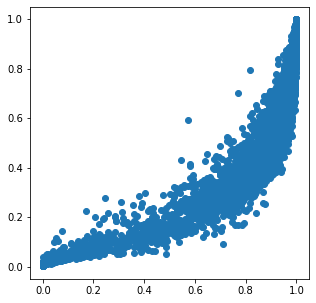

In [755]:
plt.figure(figsize=(5,5))
plt.scatter(fdr_vec, p_values)
# plt.scatter(fdr_vec[fdr_vec<0.2], p_values[fdr_vec<0.2])

## Discriminant Analysis


In [1291]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score

### LDA

In [1509]:
# lda = LinearDiscriminantAnalysis(priors=[0.9,0.1])
lda = LinearDiscriminantAnalysis()

In [1510]:
lda_model = lda.fit(x_train, y_train)

In [1511]:
print(F"priors: {lda_model.priors_}")
print(F"means: {lda_model.means_}")
print(F"Coeffs: {lda_model.coef_}")

priors: [0.5 0.5]
means: [[ 0.02384398 -0.00791645 -0.01128096  0.00233339 -0.00501667 -0.0043035
   0.01104084  0.00595032 -0.00767235  0.02285634]
 [ 0.99592489  1.00199357  1.00482415  0.9923917   0.00617766  0.01118413
  -0.01644544 -0.00125865 -0.00211109  0.01100623]]
Coeffs: [[ 0.41889829  0.46974849  0.47443701  0.45871998  0.02046772  0.03626166
  -0.02794636  0.00355071  0.00725617 -0.0322791 ]]


In [1512]:
lda_predictions = lda.predict(x_mat)
lda_probabilities = lda.predict_proba(x_mat)
lda_p_values = 1 - lda_probabilities[:,1]

In [1513]:
print(confusion_matrix(y_vec, lda_predictions))

[[7300 1700]
 [ 282  718]]


### QDA

In [1514]:
# qda = QuadraticDiscriminantAnalysis(priors=[0.9,0.1])
qda = QuadraticDiscriminantAnalysis()

In [1515]:
qda_model = qda.fit(x_train, y_train)

In [1516]:
print(F"priors: {qda_model.priors_}")
print(F"means: {qda_model.means_}")

priors: [0.5 0.5]
means: [[ 0.02384398 -0.00791645 -0.01128096  0.00233339 -0.00501667 -0.0043035
   0.01104084  0.00595032 -0.00767235  0.02285634]
 [ 0.99592489  1.00199357  1.00482415  0.9923917   0.00617766  0.01118413
  -0.01644544 -0.00125865 -0.00211109  0.01100623]]


In [1517]:
qda_predictions = qda.predict(x_mat)
qda_probabilities = qda.predict_proba(x_mat)
qda_p_values = 1 - qda_probabilities[:,1]

In [1518]:
print(confusion_matrix(y_vec, qda_predictions))

[[7474 1526]
 [ 201  799]]


#### Discriminant Analysis Graphs

LDA confusion:
 [[7300 1700]
 [ 282  718]]

QDA confusion:
 [[7474 1526]
 [ 201  799]]



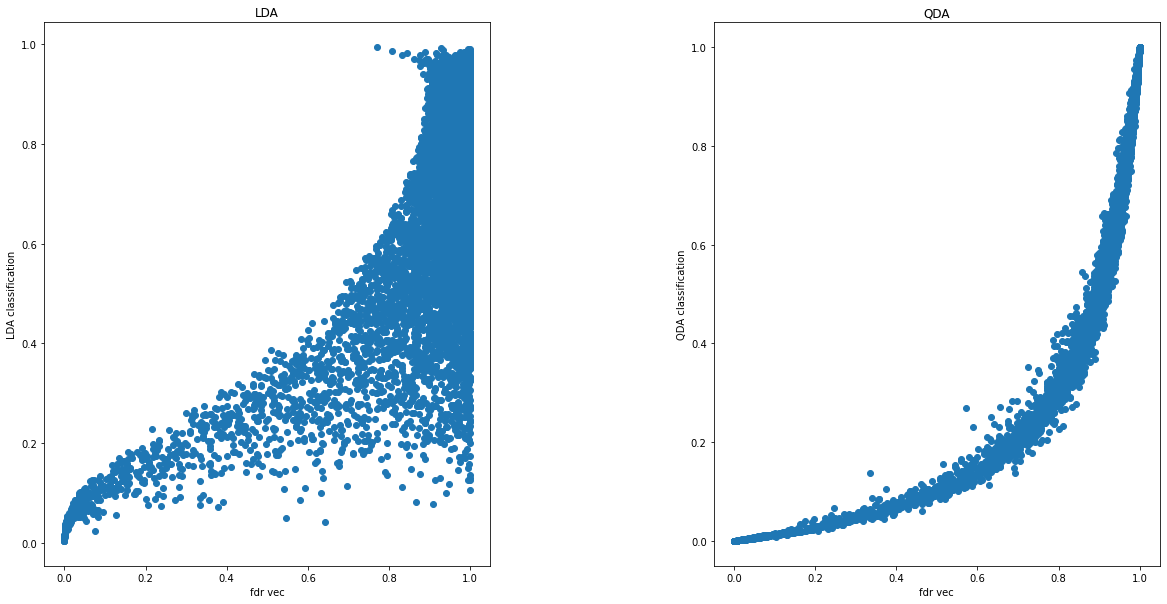

In [1519]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1,2, wspace=0.5)
axes = gs.subplots()
lda_plot = axes[0]
qda_plot = axes[1]

lda_plot.scatter(fdr_vec, lda_p_values)
lda_plot.set_title("LDA")
lda_plot.set_xlabel("fdr vec")
lda_plot.set_ylabel("LDA classification")

qda_plot.scatter(fdr_vec, qda_p_values)
qda_plot.set_title("QDA")
qda_plot.set_xlabel("fdr vec")
qda_plot.set_ylabel("QDA classification")

print(F"LDA confusion:\n {confusion_matrix(y_vec, lda_predictions)}\n")
print(F"QDA confusion:\n {confusion_matrix(y_vec, qda_predictions)}\n")

Text(0, 0.5, 'QDA for FDR<0.2')

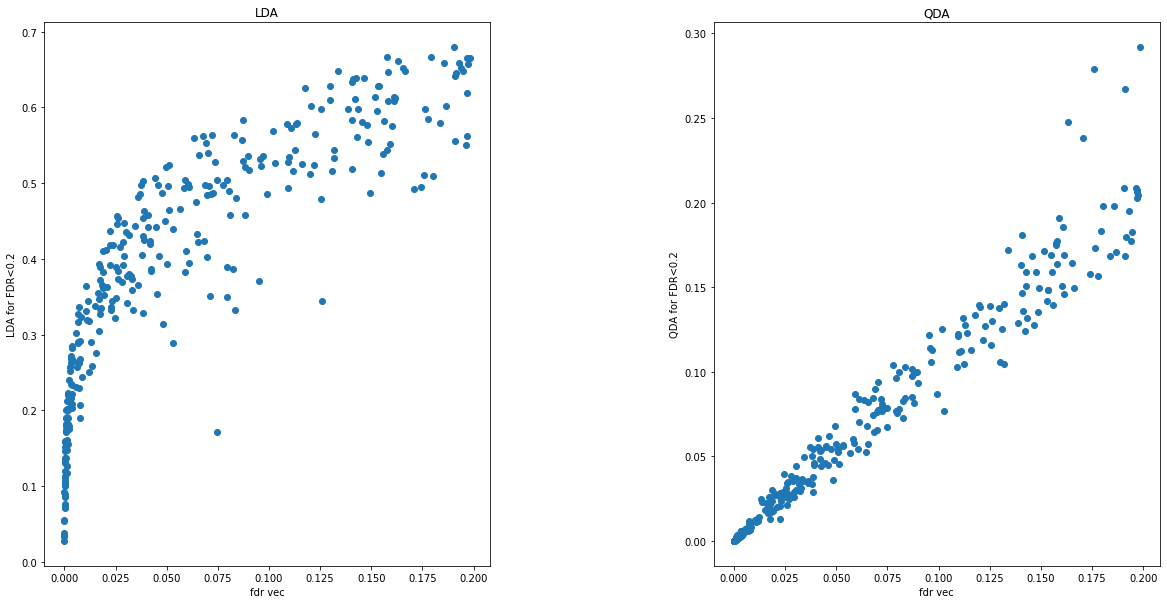

In [1506]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1,2, wspace=0.5)
axes = gs.subplots()
lda_02_plot = axes[0]
qda_02_plot = axes[1]

lda_02_plot.scatter(fdr_vec[fdr_vec<0.2], lda_p_values[fdr_vec<0.2])
lda_02_plot.set_title("LDA")
lda_02_plot.set_xlabel("fdr vec")
lda_02_plot.set_ylabel("LDA for FDR<0.2")

qda_02_plot.scatter(fdr_vec[fdr_vec<0.2], qda_p_values[fdr_vec<0.2])
qda_02_plot.set_title("QDA")
qda_02_plot.set_xlabel("fdr vec")
qda_02_plot.set_ylabel("QDA for FDR<0.2")


## Presentation

In [772]:
fpr, tpr, threasholds = sklearn.metrics.roc_curve(np.concatenate([np.repeat(False, 9000), np.repeat(True, 1000)]),p_values.numpy())    

In [811]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [847]:
BINARY_LABEL = Literal[0, 1]
def plot_roc_curves(p_values_ll: Sequence[npt.NDArray[np.float64]], y_true: BINARY_LABEL, model_names: Sequence[str]) -> None:
    '''
    Plot the ROC curve, and present AUC score for each p_values list. Notice that this assumes all p_values lists are of the same
    dimension.
    
    Parameters:
        p_values_ll: a sequence of p_value lists. Each such list is specified as a numpy array, and is generated by the model 
                        named in the corresponding `model_names` parameter.
        y_true: a sequence of the true labels.
        model_names: a sequence of names, with dimension equal to len(p_values_ll), representing the model that generated the specific 
                        p_values list.
    '''
    roc_curves = []
    colors = iter(('b', 'g', 'r', 'c', 'm', 'y', 'k')) # we'll be used to assign colors to a curve. Max 7 curves lol
    markers = iter(("o","v","^","<",">","1","2","3","4","8","s"))
    model_names = iter(model_names)
    
    # Create the curves
    for pvals in p_values_ll:
        fpr, tpr, threasholds = sklearn.metrics.roc_curve(y_true, pvals)
        auc_value = round(auc(fpr, tpr),5)
        roc_curves.append({"fpr": fpr, "tpr": tpr, "threasholds": threasholds, "auc": auc_value, "name": next(model_names), "color": next(colors), 
                           "marker": next(markers)})
    
    # Plot the curves
    plt.figure(figsize=(12,12))
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05]) # Give some margin to see the top of the curve
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    for curve in roc_curves:
        plt.plot(
            curve["fpr"],
            curve["tpr"],
            color=curve["color"],
            lw=4,
            label=F"{curve['name']} (AUC: {curve['auc']})" ,
            marker=curve["marker"]
        )
    plt.legend(loc="lower right")
    plt.show()

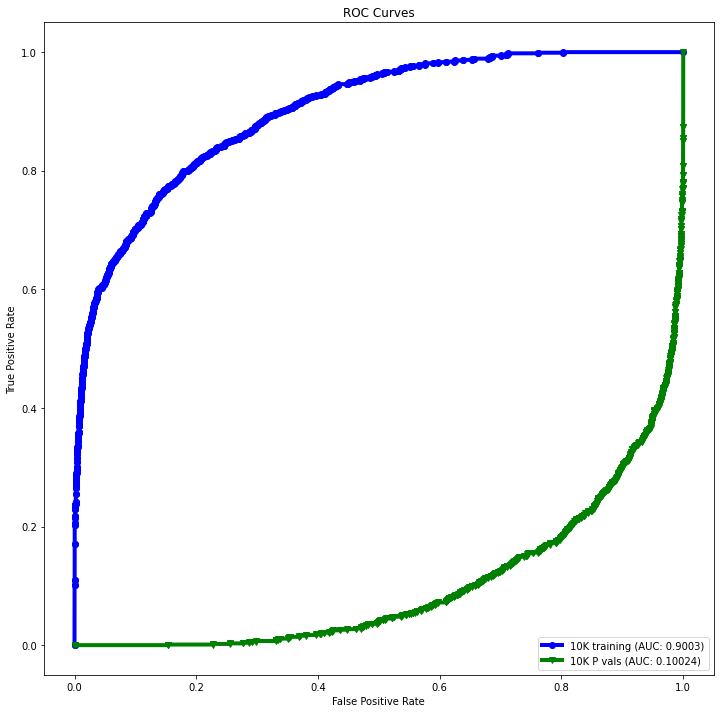

In [848]:
plot_roc_curves((all_preds_mean.numpy(), p_values.numpy()), np.concatenate([np.repeat(False, 9000), np.repeat(True, 1000)]), ("10K training", "10K P vals"))